# Simulations

## Imports

In [1]:
from statistics import *
from visualization import *
from empirical_model import *
from logistic_regression import *
from occupancy_detection import *
from maxent import *
from scipy.special import expit

## Data generation for the 8 scenarios

In [2]:
class Simulation:
    
    LABELS = np.array([["Steep, constant", "Steep, positive", "Steep, negative", "Steep, independent"], 
                   ["Gentle, constant", "Gentle, positive", "Gentle, negative", "Gentle, independent"]])
    
    SCENARIOS = [(i, j) for i in range(2) for j in range(4)]
    
    def __init__(self, n_train=400, K=2, min_size=1, scenarios=SCENARIOS):

        # Train data
        self.n_train = n_train
        self.K = K
        self.scenarios = scenarios
        self.cA_train = np.random.uniform(-np.sqrt(3), np.sqrt(3), n_train)
        self.cB_train = np.random.uniform(-np.sqrt(3), np.sqrt(3), n_train)
        train_subsets = Statistics.get_subsets([self.cA_train, self.cB_train, self.cA_train ** 2,
                                               self.cB_train ** 2, self.cA_train * self.cB_train], min_size=min_size)
        self.X_train = [np.array(subset).transpose() for subset in train_subsets]
        # Shape of X_train: (n_scenarios, n_train, m)
        
        # Probabilities of occupancy
        psi = np.array([expit(1 + 3 * self.cA_train), expit(self.cA_train)])  # Steep, gentle
        self.psi_train = np.tile(psi[:, np.newaxis, :], (1, 4, 1))

        # Conditional probabilities of detection
        p = np.array([n_train * [0.5], expit(self.cA_train),
                       expit(-self.cA_train), expit(self.cB_train)])  # Constant, positive, negative, independent
        self.p_train = np.tile(p[np.newaxis, :, :], (2, 1, 1))

        # Probabilities of detection, with 1 trial
        self.d_train = self.p_train * self.psi_train

        # Probabilities of detection with K trials
        self.psk_train = 1 - (1 - self.p_train) ** K
        self.dsk_train = self.psk_train * self.psi_train

        self.Z_train = np.random.binomial(1, self.psi_train) # Binary draw for occupancy, shape (2, 4, n_train)
        self.Y_K_train = np.random.binomial(K, self.Z_train * self.d_train) # Binomial draw for detection
        self.Y_train = 1 * (self.Y_K_train != 0) # Binary detection, shape (2, 4, n_train)
        
        # Test data
        cA_test, cB_test = np.linspace(-np.sqrt(3), np.sqrt(3), 100), np.linspace(-np.sqrt(3), np.sqrt(3), 100)
        cB_test = np.flip(cB_test)
        self.cA_grid, self.cB_grid = np.meshgrid(cA_test, cB_test)
        self.cA_test, self.cB_test = np.ravel(self.cA_grid), np.ravel(self.cB_grid)
        self.n_test = len(self.cA_test)
        test_subsets = Statistics.get_subsets([self.cA_test, self.cB_test, self.cA_test ** 2,
                                              self.cB_test ** 2, self.cA_test * self.cB_test], min_size=min_size)
        self.X_test = [np.array(subset).transpose() for subset in test_subsets]
        psi_test = np.array([expit(1 + 3 * self.cA_test), expit(self.cA_test)])  # Steep, gentle
        self.psi_test = np.tile(psi_test[:, np.newaxis, :], (1, 4, 1))
        p_test = np.array([self.n_test * [0.5], expit(self.cA_test),
                       expit(-self.cA_test), expit(self.cB_test)])  # Constant, positive, negative, independent
        self.p_test = np.tile(p_test[np.newaxis, :, :], (2, 1, 1))
        self.d_test = self.p_test * self.psi_test
        self.psk_test = 1 - (1 - self.p_test) ** K
        self.dsk_test = self.psk_test * self.psi_test
        
        self.Z_test = np.random.binomial(1, self.psi_test) # Binary draw for occupancy
        self.Y_K_test = np.random.binomial(K, self.Z_test * self.d_test) # Binomial draw for detection
        self.Y_test = 1 * (self.Y_K_train != 0) # Binary detection, shape (2, 4, n_train)
        
        self.em_models = None
        self.lr_models = None
        self.od_models = None
        
    def create_models(self, verbose=True):
        lr_models = [4*[None], 4*[None]]
        em_models = [4*[None], 4*[None]]
        od_models = [4*[None], 4*[None]]
        maxent_models = [4*[None], 4*[None]]
        lr_ids = [4*[None], 4*[None]]
        em_ids = [4*[None], 4*[None]]
        od_ids = [4*[None], 4*[None]]
        maxent_ids = [4*[None], 4*[None]]

        if verbose:
            print("New simulation")
        for i in range(2):
            for j in range(4):
                if (i, j) in self.scenarios:
                    if verbose:
                        print("Scenario", i, j)
                    occupancy_label = self.Z_train[i, j]
                    y = self.Y_train[i, j]
                    y_K = self.Y_K_train[i, j]

                    lr_family = []
                    em_family = []
                    od_family = []
                    maxent_family = []

                    for x in self.X_train:

                        # Logistic regression
                        lr_model = LogisticRegression()
                        lr_model.fit(x, y)
                        lr_family.append(lr_model)

                        # Empirical model
                        em_model = EmpiricalModel()
                        em_model.fit(x, y)
                        em_family.append(em_model)

                        # Occupancy-detection model
                        od_model = OccupancyDetection(x, y_K, K=self.K)
                        od_model.fit()
                        od_family.append(od_model)

                        # Maximum Entropy model
                        presence, background = x[y == 1], x
                        maxent_model = Maxent(presence, background)
                        maxent_model.fit()
                        maxent_family.append(maxent_model)

                    lr_ids[i][j] = Simulation.get_best_model(lr_family)[0]
                    lr_models[i][j] = lr_family

                    em_ids[i][j] = Simulation.get_best_model(em_family)[0]
                    em_models[i][j] = em_family

                    od_ids[i][j] = Simulation.get_best_model(od_family)[0]
                    od_models[i][j] = od_family

                    maxent_ids[i][j] = Simulation.get_best_model(maxent_family)[0]
                    maxent_models[i][j] = maxent_family

                    if verbose:
                        print("LR id: ", lr_ids[i][j])
                        print("EM id: ", em_ids[i][j])
                        print("OD id: ", od_ids[i][j])
                        print("Maxent id: ", maxent_ids[i][j])
                    
        self.lr_models = lr_models
        self.em_models = em_models
        self.od_models = od_models
        self.maxent_models = maxent_models
        self.lr_ids = lr_ids
        self.em_ids = em_ids
        self.od_ids = od_ids
        self.maxent_ids = maxent_ids
                
    def get_best_model(family):
        """
        Returns the model with the lowest Akaike information criterion (AIC)
        """

        aics = [model.get_aic() for model in family]
        id_ = np.argmin(aics)

        return id_, family[id_]
    
    def get_best_models(self):
        lr = [4*[None], 4*[None]]
        od = [4*[None], 4*[None]]
        em = [4*[None], 4*[None]]
        maxent = [4*[None], 4*[None]]
        for i in range(2):
            for j in range(4):
                if (i, j) in self.scenarios:
                    od_models = self.od_models[i][j]
                    lr_models = self.lr_models[i][j]
                    em_models = self.em_models[i][j]
                    maxent_models = self.maxent_models[i][j]

                    # Extracting the best models
                    od_model = Simulation.get_best_model(od_models)[1]
                    lr_model = Simulation.get_best_model(lr_models)[1]
                    em_model = Simulation.get_best_model(em_models)[1]
                    maxent_model = Simulation.get_best_model(maxent_models)[1]

                    # Extracting data
                    y_proba = self.psi_test[i][j] # Between 0 and 1
                    y_test = self.Z_test[i][j]

                    x_test = self.X_test[self.od_ids[i][j]]
                    auc = od_model.get_auc(x_test, y_test)
                    rmse = od_model.get_rmse(x_test, y_proba)
                    spearman = od_model.get_spearman(x_test, y_proba)
                    od[i][j] = od_model

                    x_test = self.X_test[self.lr_ids[i][j]]
                    auc = lr_model.get_auc(x_test, y_test)
                    rmse = lr_model.get_rmse(x_test, y_proba)
                    spearman = lr_model.get_spearman(x_test, y_proba)
                    lr[i][j] = lr_model

                    x_test = self.X_test[self.em_ids[i][j]]
                    auc = em_model.get_auc(x_test, y_test)
                    rmse = em_model.get_rmse(x_test, y_proba)
                    spearman = em_model.get_spearman(x_test, y_proba)
                    em[i][j] = em_model

                    x_test = self.X_test[self.maxent_ids[i][j]]
                    auc = maxent_model.get_auc(x_test, y_test)
                    rmse = maxent_model.get_rmse(x_test, y_proba)
                    spearman = maxent_model.get_spearman(x_test, y_proba)
                    maxent[i][j] = maxent_model
                
        return np.array(lr), np.array(od), np.array(em), np.array(maxent)
    
    
    def plot_relationships(self):
        plt.rcParams['figure.figsize'] = (15, 8)
        fig, axs = plt.subplots(4, 2)
        for i in range(4):
            for j in range(2):
                if (i, j) in self.scenarios:
                    axs[i, j].scatter(self.cA_train, self.psi_train[j, i], s=1, label="phi (occupancy)", alpha=0.1)
                    axs[i, j].scatter(self.cA_train, self.p_train[j, i], s=1, label="p (conditional detection)", alpha=0.1)
                    axs[i, j].scatter(self.cA_train, self.d_train[j, i], s=1, label="d (detection for one trial)", alpha=0.1)
                    axs[i, j].scatter(self.cA_train, self.dsk_train[j, i], s=1, label="dk (detection for the K trials)", alpha=0.1)
                    axs[i, j].set_title(Simulation.LABELS[j, i])

        for ax in axs.flat:
            ax.set(xlabel='Covariable cA', ylabel='Probability')
            ax.label_outer()

        fig.tight_layout()
        plt.legend()
        plt.show()
        
    def plot_best_models(self, i, j):
        lr_models, od_models, em_models, maxent_models = Simulation.get_best_models(self)
        od_model = od_models[i][j]
        lr_model = lr_models[i][j]
        em_model = em_models[i][j]
        maxent_model = maxent_models[i][j]

        plt.rcParams['figure.figsize'] = (15, 6)
        fig, axs = plt.subplots(2, 5)

        psi_grid = self.psi_test[i][j].reshape(self.cA_grid.shape)
        axs[0, 0].matshow(psi_grid, cmap='jet_r', alpha=0.6)
        axs[0, 0].scatter(50 * (self.cA_train / np.sqrt(3) + 1), 50 * (-self.cB_train / np.sqrt(3) + 1),
                          cmap='jet_r', c=self.Z_train[i, j], alpha=0.3, s=12)
        axs[0, 0].set_title('Probability of occupancy')

        dsk_grid = self.dsk_test[i][j].reshape(self.cA_grid.shape)
        axs[1, 0].matshow(dsk_grid , cmap='jet_r', alpha=0.6)
        axs[1, 0].scatter(50 * (self.cA_train / np.sqrt(3) + 1), 50 * (-self.cB_train / np.sqrt(3) + 1),
                          cmap='jet_r', c=self.Y_train[i, j], alpha=0.3, s=12)
        axs[1, 0].set_title('Probability of detection')

        od_occupancy, od_detection = od_model.predict(self.X_test[self.od_ids[i][j]])
        od_occupancy, od_detection = od_occupancy.reshape(self.cA_grid.shape), od_detection.reshape(self.cA_grid.shape)
        axs[0, 1].matshow(od_occupancy, cmap='jet_r')
        title = 'OD (occupancy): RMSE=' + str(od_model.rmse)[: 4]
        title += '\nAUC=' + str(od_model.auc)[: 4] + ' Spearman:' + str(od_model.spearman)[: 4]
        axs[0, 1].set_title(title)
        axs[1, 1].matshow(od_detection, cmap='jet_r')
        axs[1, 1].set_title('OD (detection)')

        lr_prediction = lr_model.predict(self.X_test[self.lr_ids[i][j]])
        lr_prediction = lr_prediction.reshape(self.cA_grid.shape)
        axs[0, 2].matshow(lr_prediction, cmap='jet_r')
        title = 'LR: RMSE=' + str(lr_model.rmse)[: 4]
        title += '\nAUC=' + str(lr_model.auc)[: 4] + ' Spearman:' + str(lr_model.spearman)[: 4]
        axs[0, 2].set_title(title)
        
        maxent_prediction = maxent_model.predict(self.X_test[self.maxent_ids[i][j]])
        maxent_prediction = maxent_prediction.reshape(self.cA_grid.shape)
        axs[0, 3].matshow(maxent_prediction, cmap='jet_r')
        title = 'Maxent: RMSE=' + str(maxent_model.rmse)[: 4]
        title += '\nAUC=' + str(maxent_model.auc)[: 4] + ' Spearman:' + str(maxent_model.spearman)[: 4]
        axs[0, 3].set_title(title)

        em_prediction = em_model.predict(self.X_test[self.em_ids[i][j]])
        em_prediction = em_prediction.reshape(self.cA_grid.shape)
        axs[0, 4].matshow(em_prediction, cmap='jet_r')
        title = "EM: RMSE=" + str(em_model.rmse)[: 4] + '\nAUC=' + str(em_model.auc)[: 4]
        title += ' Spearman:' + str(em_model.spearman)[: 4]
        axs[0, 4].set_title(title)
        
        axs[1, 2].set_axis_off()
        axs[1, 3].set_axis_off()
        axs[1, 4].set_axis_off()

        plt.show()

In [3]:
simul = Simulation(n_train=300, min_size=1, scenarios =[(0, 3)])
#simul.plot_relationships()
simul.create_models()

New simulation
Scenario 0 3
LR id:  30
EM id:  17
OD id:  15
Maxent id:  25


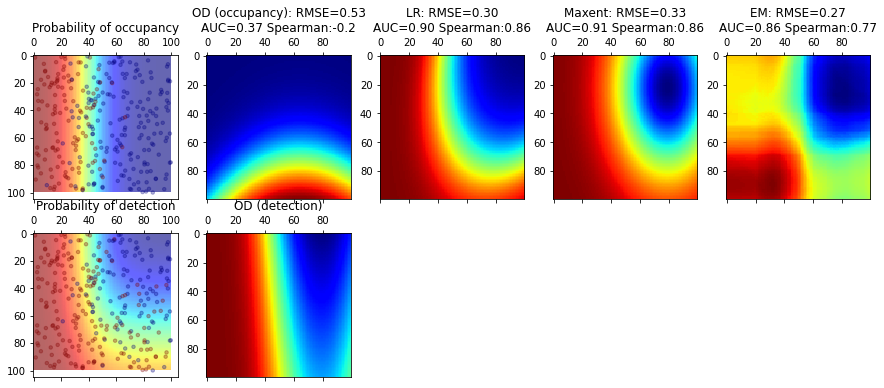

In [4]:
simul.plot_best_models(0, 3)

## Range of simulations

In [5]:
n_trains = [100, 400, 1000, 2000]
n_simul = 100

lr_rmse = np.zeros((2, 4, len(n_trains), n_simul))
od_rmse = np.zeros((2, 4, len(n_trains), n_simul))
em_rmse = np.zeros((2, 4, len(n_trains), n_simul))
maxent_rmse = np.zeros((2, 4, len(n_trains), n_simul))

lr_auc = np.zeros((2, 4, len(n_trains), n_simul))
od_auc = np.zeros((2, 4, len(n_trains), n_simul))
em_auc = np.zeros((2, 4, len(n_trains), n_simul))
maxent_auc = np.zeros((2, 4, len(n_trains), n_simul))

lr_spearman = np.zeros((2, 4, len(n_trains), n_simul))
od_spearman = np.zeros((2, 4, len(n_trains), n_simul))
em_spearman = np.zeros((2, 4, len(n_trains), n_simul))
maxent_spearman = np.zeros((2, 4, len(n_trains), n_simul))

for i, n_train in enumerate(n_trains):
    for j in range(n_simul):
        print("New batch", j, i)
        simul = Simulation(n_train=n_train, min_size=1)
        simul.create_models(verbose=False)
        
        lr_models, od_models, em_models, maxent_models = simul.get_best_models()
        for k in range(2):
            for l in range(4):
                if (k, l) in simul.scenarios:
                    od_model = od_models[k][l]
                    lr_model = lr_models[k][l]
                    em_model = em_models[k][l]
                    maxent_model = maxent_models[k][l]

                    lr_rmse[k, l, i, j] = lr_model.rmse
                    od_rmse[k, l, i, j] = od_model.rmse
                    em_rmse[k, l, i, j] = em_model.rmse
                    maxent_rmse[k, l, i, j] = maxent_model.rmse

                    lr_auc[k, l, i, j] = lr_model.auc
                    od_auc[k, l, i, j] = od_model.auc
                    em_auc[k, l, i, j] = em_model.auc
                    maxent_auc[k, l, i, j] = maxent_model.auc

                    lr_spearman[k, l, i, j] = lr_model.spearman
                    od_spearman[k, l, i, j] = od_model.spearman
                    em_spearman[k, l, i, j] = em_model.spearman
                    maxent_spearman[k, l, i, j] = maxent_model.spearman

New batch 0 0
New batch 1 0
New batch 2 0
New batch 3 0
New batch 4 0
New batch 5 0
New batch 6 0
New batch 7 0
New batch 8 0
New batch 9 0
New batch 10 0
New batch 11 0
New batch 12 0
New batch 13 0
New batch 14 0
New batch 15 0
New batch 16 0
New batch 17 0
New batch 18 0
New batch 19 0
New batch 20 0
New batch 21 0
New batch 22 0
New batch 23 0
New batch 24 0
New batch 25 0
New batch 26 0
New batch 27 0
New batch 28 0
New batch 29 0
New batch 30 0
New batch 31 0
New batch 32 0
New batch 33 0
New batch 34 0
New batch 35 0
New batch 36 0
New batch 37 0
New batch 38 0
New batch 39 0
New batch 40 0
New batch 41 0
New batch 42 0
New batch 43 0
New batch 44 0
New batch 45 0
New batch 46 0
New batch 47 0
New batch 48 0
New batch 49 0
New batch 50 0
New batch 51 0
New batch 52 0
New batch 53 0
New batch 54 0
New batch 55 0
New batch 56 0
New batch 57 0
New batch 58 0
New batch 59 0
New batch 60 0
New batch 61 0
New batch 62 0
New batch 63 0
New batch 64 0
New batch 65 0
New batch 66 0
New b

Gentle, independent


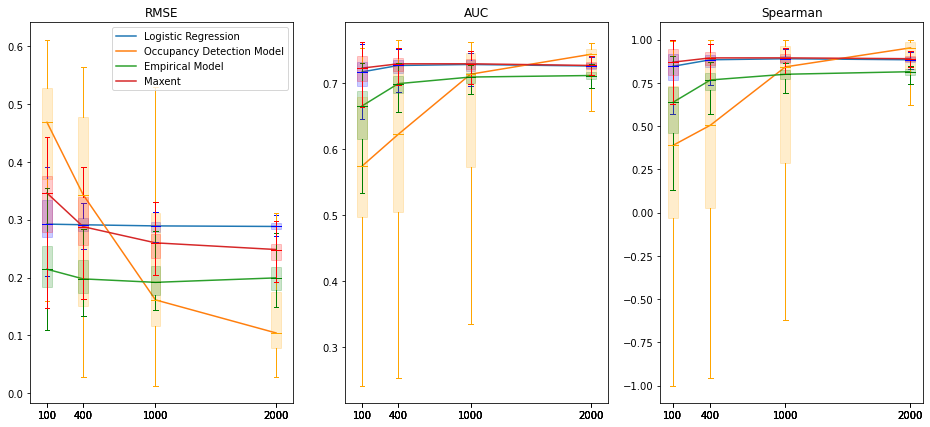

In [15]:
plt.rcParams['figure.figsize'] = (16, 7)

for k in range(2):
    for l in range(4):
        if k == 1 and l == 3:
            print(Simulation.LABELS[k, l])
            fig, axs = plt.subplots(1, 3)

            plt.xlim(0, 2100)

            axs[0].plot(n_trains, np.median(lr_rmse[k, l], axis=1), label='Logistic Regression')
            axs[0].plot(n_trains, np.median(od_rmse[k, l], axis=1), label='Occupancy Detection Model')
            axs[0].plot(n_trains, np.median(em_rmse[k, l], axis=1), label='Empirical Model')
            axs[0].plot(n_trains, np.median(maxent_rmse[k, l], axis=1), label='Maxent')
            box = axs[0].boxplot(lr_rmse[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('blue')
            for patch in box['boxes']:
                patch.set_facecolor('blue')
                patch.set_alpha(0.2)
            box = axs[0].boxplot(od_rmse[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('orange')
            for patch in box['boxes']:
                patch.set_facecolor('orange')
                patch.set_alpha(0.2)
            box = axs[0].boxplot(em_rmse[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('green')
            for patch in box['boxes']:
                patch.set_facecolor('green')
                patch.set_alpha(0.2)
            box = axs[0].boxplot(maxent_rmse[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('red')
            for patch in box['boxes']:
                patch.set_facecolor('red')
                patch.set_alpha(0.2)
            axs[0].set_title('RMSE')
            axs[0].legend()

            axs[1].plot(n_trains, np.median(lr_auc[k, l], axis=1), label='Logistic Regression')
            axs[1].plot(n_trains, np.median(od_auc[k, l], axis=1), label='Occupancy Detection Model')
            axs[1].plot(n_trains, np.median(em_auc[k, l], axis=1), label='Empirical Model')
            axs[1].plot(n_trains, np.median(maxent_auc[k, l], axis=1), label='Maxent')
            box = axs[1].boxplot(lr_auc[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('blue')
            for patch in box['boxes']:
                patch.set_facecolor('blue')
                patch.set_alpha(0.2)
            box = axs[1].boxplot(od_auc[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('orange')
            for patch in box['boxes']:
                patch.set_facecolor('orange')
                patch.set_alpha(0.2)
            box = axs[1].boxplot(em_auc[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('green')
            for patch in box['boxes']:
                patch.set_facecolor('green')
                patch.set_alpha(0.2)
            box = axs[1].boxplot(maxent_auc[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('red')
            for patch in box['boxes']:
                patch.set_facecolor('red')
                patch.set_alpha(0.2)
            axs[1].set_title('AUC')

            axs[2].plot(n_trains, np.median(lr_spearman[k, l], axis=1), label='Logistic Regression')
            axs[2].plot(n_trains, np.median(od_spearman[k, l], axis=1), label='Occupancy Detection Model')
            axs[2].plot(n_trains, np.median(em_spearman[k, l], axis=1), label='Empirical Model')
            axs[2].plot(n_trains, np.median(maxent_spearman[k, l], axis=1), label='Maxent')
            box = axs[2].boxplot(lr_spearman[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('blue')
            for patch in box['boxes']:
                patch.set_facecolor('blue')
                patch.set_alpha(0.2)
            box = axs[2].boxplot(od_spearman[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('orange')
            for patch in box['boxes']:
                patch.set_facecolor('orange')
                patch.set_alpha(0.2)
            box = axs[2].boxplot(em_spearman[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('green')
            for patch in box['boxes']:
                patch.set_facecolor('green')
                patch.set_alpha(0.2)
            box = axs[2].boxplot(maxent_spearman[k, l].transpose(), positions=n_trains,
                                 patch_artist=True, widths=80, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                for item in box[element]:
                    item.set_color('red')
            for patch in box['boxes']:
                patch.set_facecolor('red')
                patch.set_alpha(0.2)
            axs[2].set_title('Spearman')

            plt.show()

In [20]:
print(np.median(em_rmse, axis=3).shape)
print(np.median(lr_rmse, axis=3))
print(np.median(od_rmse, axis=3))
print(np.median(maxent_rmse, axis=3))

(2, 4, 4)
[[[0.2459039  0.2286887  0.23144147 0.22972523]
  [0.19646724 0.18340741 0.17603267 0.17799201]
  [0.40193348 0.39708738 0.38507732 0.38767871]
  [0.31370573 0.29544297 0.3007722  0.29914161]]

 [[0.26535583 0.26060866 0.25562057 0.25657755]
  [0.22664548 0.22020036 0.21797776 0.21640953]
  [0.37314638 0.35840439 0.35820005 0.35688107]
  [0.29218339 0.2910391  0.28908475 0.28812921]]]
[[[0.25481901 0.12309707 0.08591185 0.06918523]
  [0.26616792 0.15978222 0.09457816 0.07593115]
  [0.24417418 0.19266959 0.09269131 0.05854122]
  [0.30207512 0.18078538 0.09869627 0.08703365]]

 [[0.43092504 0.29299966 0.13702647 0.07486816]
  [0.43017045 0.19638415 0.10390077 0.06950442]
  [0.52760263 0.30176898 0.1877789  0.13005253]
  [0.46800899 0.34298939 0.1613591  0.10429131]]]
[[[0.18815563 0.17233974 0.1702992  0.17045107]
  [0.21180523 0.20839687 0.20428749 0.20718649]
  [0.25493531 0.22286514 0.20913786 0.21222304]
  [0.39991953 0.36599726 0.33721372 0.33528709]]

 [[0.22644318 0.1707

In [21]:
print(np.median(em_auc, axis=3).shape)
print(np.median(lr_auc, axis=3))
print(np.median(od_auc, axis=3))
print(np.median(maxent_auc, axis=3))

(2, 4, 4)
[[[0.93725207 0.93853782 0.93947636 0.94011853]
  [0.93861597 0.94144443 0.94106706 0.94122037]
  [0.90051551 0.90323016 0.90847884 0.90784737]
  [0.91188237 0.92079163 0.92167153 0.92119342]]

 [[0.74762245 0.75106731 0.75329876 0.75468596]
  [0.74848193 0.75434266 0.75365814 0.75393188]
  [0.67475564 0.71428918 0.71583622 0.71655861]
  [0.71639828 0.72613172 0.72764287 0.72537095]]]
[[[0.8582615  0.93718609 0.93971171 0.94057632]
  [0.87287537 0.9310155  0.93915752 0.9398881 ]
  [0.87901862 0.90495866 0.93937442 0.94062053]
  [0.85150116 0.9258308  0.93634891 0.93788868]]

 [[0.61415372 0.64204665 0.7420974  0.74939447]
  [0.60857291 0.72007909 0.74876345 0.75226596]
  [0.50488516 0.65731188 0.72633737 0.75227473]
  [0.57395496 0.62197427 0.71294745 0.7431154 ]]]
[[[0.93864447 0.93795631 0.93770653 0.93858636]
  [0.93941964 0.94043834 0.93960867 0.9398422 ]
  [0.90905497 0.90715414 0.91151484 0.91055964]
  [0.92470056 0.92627837 0.92551044 0.92419536]]

 [[0.75354476 0.7522

## Notes pour meeting Emilie 16/06


dépendance variables climatiques : ajouter une copule
théorème de Sklar
autre idée : vecteurs gaussiens